# Transformers on Genome Sequences


## UMAP of Mitochondrial DNA sequences using BERT Transformers

## High-Level Intuition for the Code

### Overview

This code is designed to download mitochondrial DNA sequences from multiple organisms, process these sequences using a pre-trained BERT model, and visualize the results using UMAP and KMeans clustering. The main goal is to analyze the similarities and differences between DNA sequences from different organisms by converting them into a high-dimensional space using BERT embeddings and then reducing these dimensions for visualization and clustering.

### Why This Is Useful

1. **Pattern Identification**: By embedding DNA sequences into a high-dimensional space, we can identify patterns and similarities that may not be obvious in the raw sequence data.
2. **Functional Insights**: Clustering similar sequences can provide insights into functional regions of the DNA, helping to understand evolutionary conservation and genomic functions.
3. **Comparative Genomics**: Analyzing mitochondrial DNA from different organisms allows researchers to compare and contrast their genomic structures, which is valuable for evolutionary biology studies.

### Steps in the Code

1. **Download DNA Sequences**: The code downloads mitochondrial DNA sequences from multiple organisms using URLs from the Ensembl database.
2. **Segment the Sequences**: The DNA sequences are split into overlapping segments to ensure that each segment fits into the BERT model's input constraints.
3. **Embed with BERT**: Each DNA segment is tokenized and passed through a pre-trained BERT model to generate embeddings, which are high-dimensional representations of the sequences.
4. **Dimensionality Reduction with UMAP**: The high-dimensional embeddings are reduced to a two-dimensional space using UMAP for visualization.
5. **Clustering with KMeans**: The UMAP-reduced embeddings are clustered using KMeans to identify groups of similar sequences.
6. **Visualization**: The results are visualized in a scatter plot, with different colors representing different clusters.

### Detailed Explanation

#### 1. Downloading DNA Sequences

The code starts by downloading mitochondrial DNA sequences from multiple organisms. This is done using the `requests` library to fetch gzipped FASTA files from the Ensembl database. The files are then decompressed and parsed using the `Bio.SeqIO` module from Biopython.

#### 2. Segmenting the Sequences

DNA sequences are split into smaller, overlapping segments to fit the BERT model's input constraints. This is not based on natural biological features but ensures uniform coverage of the entire sequence. For example, a sequence might be split into segments of 200 base pairs with an overlap of 100 base pairs between consecutive segments.

#### 3. Embedding with BERT

Each segment is tokenized and processed using a pre-trained BERT model. The tokenizer converts the DNA sequences into a format suitable for the BERT model, which then generates embeddings. These embeddings are high-dimensional vectors that capture the information and characteristics of the DNA segments.

#### 4. Dimensionality Reduction with UMAP

UMAP (Uniform Manifold Approximation and Projection) is used to reduce the dimensionality of the embeddings from the BERT model. This makes it possible to visualize the high-dimensional data in a two-dimensional plot while preserving the structure and relationships between the data points.

#### 5. Clustering with KMeans

KMeans clustering is applied to the UMAP-reduced embeddings to identify groups of similar sequences. Each cluster represents a set of sequences that are more similar to each other than to those in other clusters.

#### 6. Visualization

The UMAP-reduced embeddings are plotted in a scatter plot, with each point representing a DNA segment. Different colors indicate different clusters, allowing for visual inspection of the similarities and differences between the sequences from various organisms.

### Conclusion

This approach provides a systematic way to analyze and visualize DNA sequences from different organisms. By converting sequences into embeddings and using dimensionality reduction and clustering techniques, researchers can gain insights into the genomic structure and functional regions, as well as evolutionary relationships between different species.



In [24]:
# Install required libraries
# !pip install biopython requests tqdm

# Import required libraries
import requests
import gzip
from Bio import SeqIO
from tqdm import tqdm
from io import BytesIO, StringIO

def download_ensembl_dataset(url, organism_name):
    """
    Downloads and decompresses a dataset from Ensembl and associates it with an organism name.
    Parameters:
    url (str): The URL of the dataset to download.
    organism_name (str): The name of the organism the dataset belongs to.
    Returns:
    list: A list of sequence records with organism information.
    """
    print(f"Downloading dataset from {url} for {organism_name}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Check if the request was successful
    compressed_file = BytesIO(response.content)
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    text_content = decompressed_file.read().decode('utf-8')
    records = list(SeqIO.parse(StringIO(text_content), "fasta"))
    for record in records:
        record.annotations["organism"] = organism_name
    print("Download complete.")
    return records


# Updated URLs for available organisms' mitochondrial DNA
organisms_urls = {
    "Human": "http://ftp.ensembl.org/pub/release-103/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.MT.fa.gz",
    "Mouse": "http://ftp.ensembl.org/pub/release-103/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.MT.fa.gz",
    # Remove Rat as it's not available, add another example
    "Chicken": "http://ftp.ensembl.org/pub/release-103/fasta/gallus_gallus/dna/Gallus_gallus.GRCg6a.dna.chromosome.MT.fa.gz"
}

all_records = []
for organism, url in organisms_urls.items():
    try:
        records = download_ensembl_dataset(url, organism)
        all_records.extend(records)
    except Exception as e:
        print(f"Error downloading data for {organism}: {e}")

print(f"Total sequences downloaded: {len(all_records)}")

Download complete.
Download complete.
Download complete.
Total sequences downloaded: 3


#### 2. Process Sequences and Generate Embeddings
We'll process the sequences, generate embeddings, and keep track of the organism information.

In [28]:
# Function to split sequence into overlapping segments
def split_sequence(sequence, segment_length=200, overlap=100):
    return [sequence[i:i+segment_length] for i in range(0, len(sequence)-segment_length+1, segment_length-overlap)]

# Function to preprocess DNA segments for BERT
def preprocess_segments(segments, tokenizer, max_length=512):
    tokenized_segments = tokenizer(segments, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return tokenized_segments

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Split the sequences into segments and keep track of organisms
segments = []
organisms = []
for record in all_records:
    full_sequence = str(record.seq)
    organism = record.annotations["organism"]
    record_segments = split_sequence(full_sequence)
    segments.extend(record_segments)
    organisms.extend([organism] * len(record_segments))

print(f"Number of segments created: {len(segments)}")

# Preprocess segments
print("Preprocessing segments...")
tokenized_segments = preprocess_segments(segments, tokenizer)
print(f"Shape of tokenized segments: {tokenized_segments['input_ids'].shape}")

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenized_segments = {k: v.to(device) for k, v in tokenized_segments.items()}

# Generate BERT embeddings
print("Generating BERT embeddings...")
with torch.no_grad():
    outputs = model(**tokenized_segments)
    embeddings = outputs.last_hidden_state
print(f"Shape of embeddings: {embeddings.shape}")

# Convert embeddings to numpy array
embeddings_np = embeddings.cpu().numpy()

# Reduce dimensionality from 3D to 2D by averaging over the sequence length
embeddings_mean = np.mean(embeddings_np, axis=1)  # Shape: (batch_size, embedding_size)
print(f"Shape of embeddings_mean: {embeddings_mean.shape}")
print(f"Sample of embeddings_mean: {embeddings_mean[:5]}")

Loading BERT tokenizer and model...
Number of segments created: 491
Preprocessing segments...
Shape of tokenized segments: torch.Size([491, 3])
Generating BERT embeddings...
Shape of embeddings: torch.Size([491, 3, 768])
Shape of embeddings_mean: (491, 768)
Sample of embeddings_mean: [[-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]]


#### 3. Label Data Points in the Plot
Finally, we'll use UMAP to reduce dimensionality and plot the results with organism labels.

# Apply UMAP to reduce the dimensionality to 2D for visualization
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_mean)
print(f"Shape of UMAP embeddings: {umap_embeddings.shape}")
print(f"Sample of UMAP embeddings: {umap_embeddings[:5]}")

# Ensure the number of clusters does not exceed the number of samples
num_clusters = min(len(umap_embeddings), 5)

# Perform KMeans clustering on the UMAP-reduced embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(umap_embeddings)
labels = kmeans.labels_
print(f"Number of clusters: {num_clusters}")
print(f"Sample of cluster labels: {labels[:10]}")

# Plot the UMAP-reduced embeddings with organism labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar(scatter, label='Cluster Labels')
for i, organism in enumerate(organisms):
    plt.annotate(organism, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=8, alpha=0.75)
plt.title('UMAP projection of DNA sequence embeddings with organism labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('umap_plot_with_organisms.png')  # Save the plot as an image file
print("Plot saved as 'umap_plot_with_organisms.png'")
plt.show()

/home/galen/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of UMAP embeddings: (491, 2)
Sample of UMAP embeddings: [[8.160353   3.6390064 ]
 [8.759281   1.1746308 ]
 [8.108057   0.13173054]
 [8.129591   3.3947234 ]
 [5.670252   3.8309565 ]]
Number of clusters: 5
Sample of cluster labels: [4 1 0 4 4 1 1 4 1 0]


/home/galen/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Plot saved as 'umap_plot_with_organisms.png'


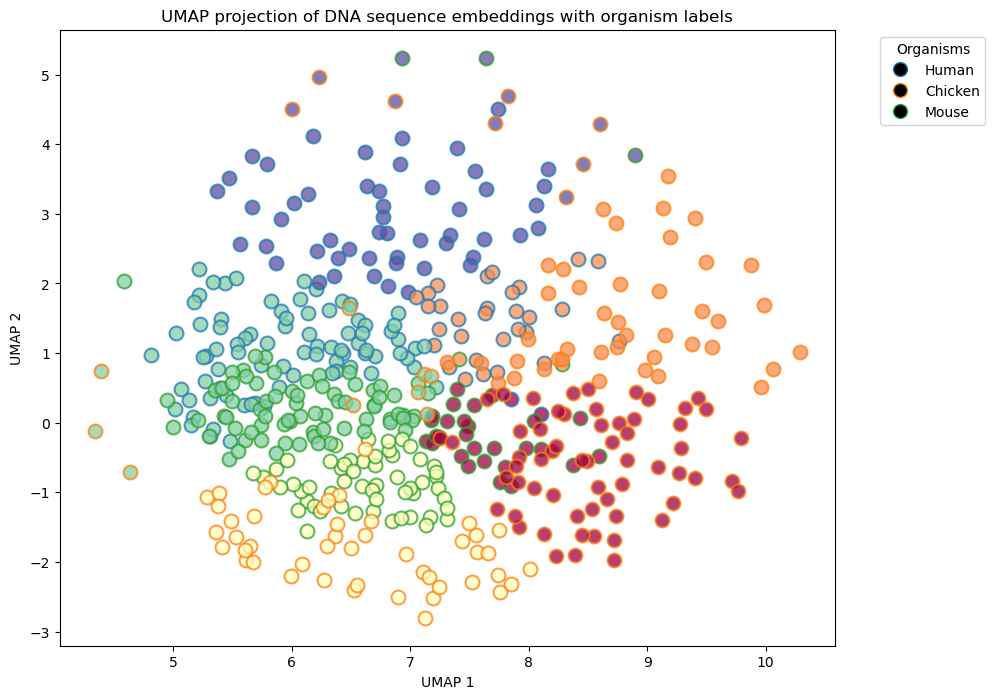

In [32]:
# Import additional libraries for plotting
import matplotlib.colors as mcolors

# Apply UMAP to reduce the dimensionality to 2D for visualization
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_mean)
print(f"Shape of UMAP embeddings: {umap_embeddings.shape}")
print(f"Sample of UMAP embeddings: {umap_embeddings[:5]}")

# Ensure the number of clusters does not exceed the number of samples
num_clusters = min(len(umap_embeddings), 5)

# Perform KMeans clustering on the UMAP-reduced embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(umap_embeddings)
labels = kmeans.labels_
print(f"Number of clusters: {num_clusters}")
print(f"Sample of cluster labels: {labels[:10]}")

# Assign colors to clusters
cluster_colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

# Assign border colors to organisms
organism_list = organisms  # Assuming organisms is a list of organism names
unique_organisms = list(set(organism_list))
border_colors = dict(zip(unique_organisms, mcolors.TABLEAU_COLORS))

# Plot the UMAP-reduced embeddings with cluster labels and organism border colors
plt.figure(figsize=(10, 8))
for i, (organism, label) in enumerate(zip(organism_list, labels)):
    x = umap_embeddings[i, 0]
    y = umap_embeddings[i, 1]
    internal_color = cluster_colors[label]
    border_color = border_colors[organism]
    plt.scatter(x, y, color=internal_color, edgecolor=border_color, s=100, linewidth=1.5, alpha=0.75)
    
# Create a legend for the organisms
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markeredgecolor=color, markersize=10, linestyle='') for color in border_colors.values()]
labels = border_colors.keys()
plt.legend(handles, labels, title="Organisms", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.colorbar(scatter, label='Cluster Labels')
plt.title('UMAP projection of DNA sequence embeddings with organism labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('umap_plot_with_organisms.png')  # Save the plot as an image file
print("Plot saved as 'umap_plot_with_organisms.png'")
plt.show()


# Try other dimension reduction techniques (PCA and T-SNE)

Download complete.
Download complete.
Download complete.
Download complete.
Total sequences downloaded: 4
Loading BERT tokenizer and model...
Number of segments created: 651
Preprocessing segments...
Shape of tokenized segments: torch.Size([651, 3])
Generating BERT embeddings...
Shape of embeddings: torch.Size([651, 3, 768])
Shape of embeddings_mean: (651, 768)
Sample of embeddings_mean: [[-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]
 [-0.40278387  0.14599584 -0.37918317 ...  0.02278816 -0.05114331
  -0.1962082 ]]
Shape of reduced embeddings: (651, 2)
Number of clusters: 5
Sample of cluster labels: [0 0 0 0 0 0 0 0 0 0]


/home/galen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Shape of reduced embeddings: (651, 2)
Number of clusters: 5
Sample of cluster labels: [2 1 0 0 0 0 0 0 0 0]


/home/galen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/galen/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of reduced embeddings: (651, 2)
Number of clusters: 5
Sample of cluster labels: [4 0 0 2 0 0 0 0 0 0]
Plot saved as 'pca_gmm_plot.png'


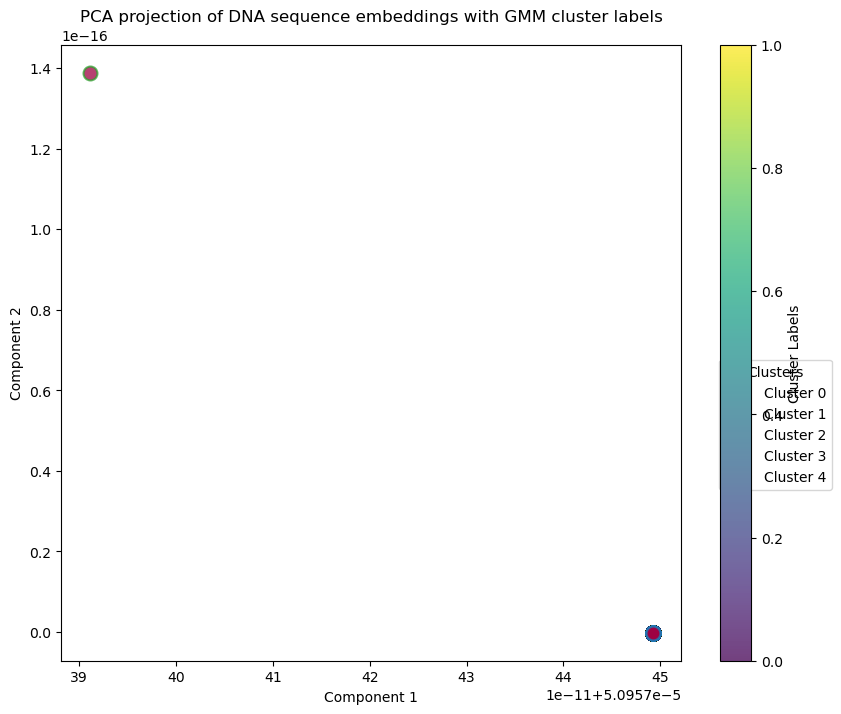

Plot saved as 'tsne_gmm_plot.png'


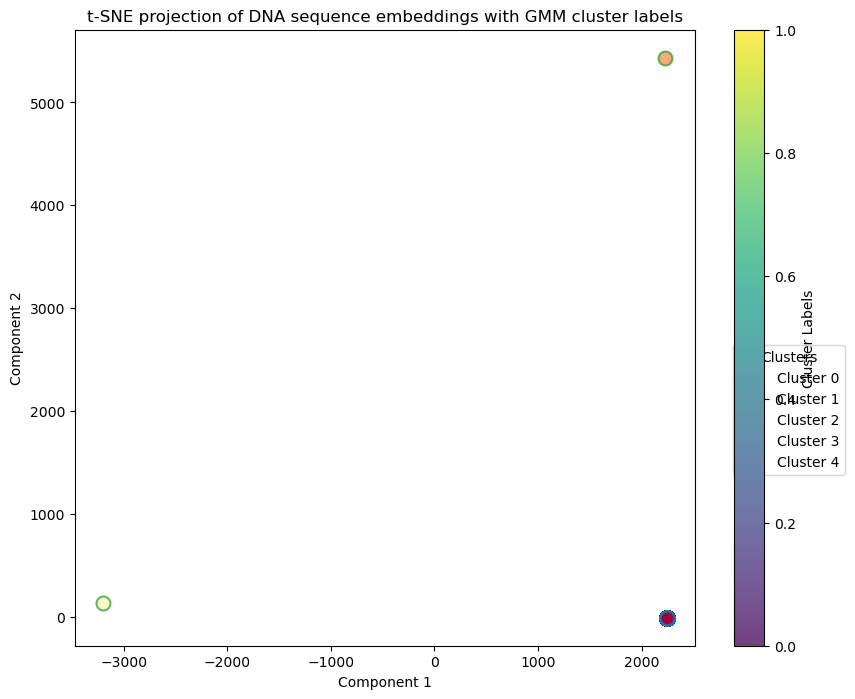

Plot saved as 'umap_gmm_plot.png'


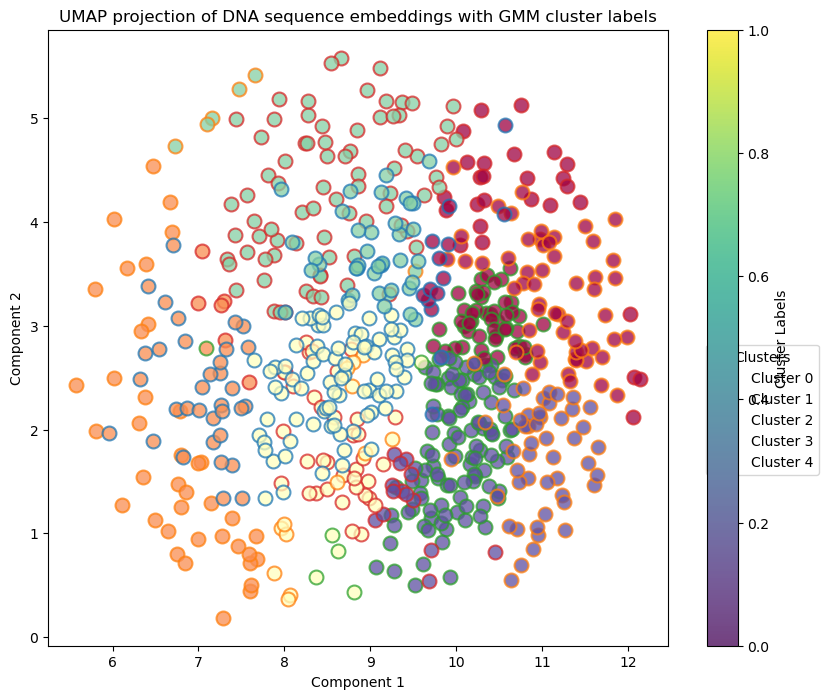

In [46]:
# Install required libraries
# !pip install biopython transformers torch tqdm umap-learn matplotlib

# Import required libraries
import torch
from transformers import BertTokenizer, BertModel
from Bio import SeqIO
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture
import requests
import gzip
from io import BytesIO, StringIO

# Define the URLs for the organisms
organisms_urls = {
    'human': 'http://ftp.ensembl.org/pub/release-103/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.MT.fa.gz',
    'mouse': 'http://ftp.ensembl.org/pub/release-103/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.MT.fa.gz',
    'rat': 'http://ftp.ensembl.org/pub/release-103/fasta/rattus_norvegicus/dna/Rattus_norvegicus.Rnor_6.0.dna.chromosome.MT.fa.gz',
    'zebrafish': 'http://ftp.ensembl.org/pub/release-103/fasta/danio_rerio/dna/Danio_rerio.GRCz11.dna.chromosome.MT.fa.gz',
}

# Function to download and decompress a dataset
def download_ensembl_dataset(url):
    print(f"Downloading dataset from {url}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    compressed_file = BytesIO(response.content)
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    text_content = decompressed_file.read().decode('utf-8')
    records = list(SeqIO.parse(StringIO(text_content), "fasta"))
    print("Download complete.")
    return records

# Download datasets
all_records = []
organisms = []
for organism, url in organisms_urls.items():
    records = download_ensembl_dataset(url)
    all_records.extend(records)
    organisms.extend([organism] * len(records))

print(f"Total sequences downloaded: {len(all_records)}")

# Function to split sequence into overlapping segments
def split_sequence(sequence, segment_length=200, overlap=100):
    return [sequence[i:i+segment_length] for i in range(0, len(sequence)-segment_length+1, segment_length-overlap)]

# Function to preprocess DNA segments for BERT
def preprocess_segments(segments, tokenizer, max_length=512):
    tokenized_segments = tokenizer(segments, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return tokenized_segments

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Split the sequences into segments
segments = []
segment_labels = []
for record, organism in zip(all_records, organisms):
    full_sequence = str(record.seq)
    record_segments = split_sequence(full_sequence)
    segments.extend(record_segments)
    segment_labels.extend([organism] * len(record_segments))

print(f"Number of segments created: {len(segments)}")

# Preprocess segments
print("Preprocessing segments...")
tokenized_segments = preprocess_segments(segments, tokenizer)
print(f"Shape of tokenized segments: {tokenized_segments['input_ids'].shape}")

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenized_segments = {k: v.to(device) for k, v in tokenized_segments.items()}

# Generate BERT embeddings
print("Generating BERT embeddings...")
with torch.no_grad():
    outputs = model(**tokenized_segments)
    embeddings = outputs.last_hidden_state
print(f"Shape of embeddings: {embeddings.shape}")

# Convert embeddings to numpy array
embeddings_np = embeddings.cpu().numpy()

# Reduce dimensionality from 3D to 2D by averaging over the sequence length
embeddings_mean = np.mean(embeddings_np, axis=1)
print(f"Shape of embeddings_mean: {embeddings_mean.shape}")
print(f"Sample of embeddings_mean: {embeddings_mean[:5]}")

# Dimensionality Reduction and Clustering
def reduce_and_cluster(embeddings_mean, method='umap'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)

    reduced_embeddings = reducer.fit_transform(embeddings_mean)
    print(f"Shape of reduced embeddings: {reduced_embeddings.shape}")
    
    num_clusters = min(len(reduced_embeddings), 5)
    gmm = GaussianMixture(n_components=num_clusters, random_state=0).fit(reduced_embeddings)
    labels = gmm.predict(reduced_embeddings)
    print(f"Number of clusters: {num_clusters}")
    print(f"Sample of cluster labels: {labels[:10]}")
    
    return reduced_embeddings, labels

# Reduce and cluster using PCA
reduced_embeddings_pca, labels_pca = reduce_and_cluster(embeddings_mean, method='pca')
# Reduce and cluster using t-SNE
reduced_embeddings_tsne, labels_tsne = reduce_and_cluster(embeddings_mean, method='tsne')

reduced_embeddings_umap, labels_umap = reduce_and_cluster(embeddings_mean, method='umap')

# Assign colors to clusters
cluster_colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels_umap))))

# Assign border colors to organisms
unique_organisms = list(set(segment_labels))
border_colors = dict(zip(unique_organisms, mcolors.TABLEAU_COLORS))

# Function to plot the embeddings
def plot_embeddings(reduced_embeddings, labels, title, filename):
    plt.figure(figsize=(10, 8))
    for i, (organism, label) in enumerate(zip(segment_labels, labels)):
        x = reduced_embeddings[i, 0]
        y = reduced_embeddings[i, 1]
        internal_color = cluster_colors[label]
        border_color = border_colors[organism]
        plt.scatter(x, y, color=internal_color, edgecolor=border_color, s=100, linewidth=1.5, alpha=0.75)

    # Create a legend for the organisms
    organism_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markeredgecolor=color, markersize=10, linestyle='') for color in border_colors.values()]
    organism_labels = border_colors.keys()

    # Create a legend for the clusters
    cluster_handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='') for color in cluster_colors]
    cluster_labels = [f"Cluster {i}" for i in range(len(cluster_colors))]

    plt.legend(organism_handles, organism_labels, title="Organisms", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(cluster_handles, cluster_labels, title="Clusters", bbox_to_anchor=(1.05, 0.5), loc='upper left')

    plt.colorbar(label='Cluster Labels')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(filename)  # Save the plot as an image file
    print(f"Plot saved as '{filename}'")
    plt.show()

# Plot PCA
plot_embeddings(reduced_embeddings_pca, labels_pca, 'PCA projection of DNA sequence embeddings with GMM cluster labels', 'pca_gmm_plot.png')

# Plot t-SNE
plot_embeddings(reduced_embeddings_tsne, labels_tsne, 't-SNE projection of DNA sequence embeddings with GMM cluster labels', 'tsne_gmm_plot.png')

plot_embeddings(reduced_embeddings_umap, labels_umap, 'UMAP projection of DNA sequence embeddings with GMM cluster labels', 'umap_gmm_plot.png')


# Try DNABERT instead of a generic BERT


Using DNABERT, we are plotting contextualized embeddings of DNA sequences rather than raw embeddings. Here’s a breakdown:

### Contextualized Embeddings
- **DNABERT**: A DNA-specific adaptation of BERT, designed to capture contextual relationships in DNA sequences.
- **Embeddings**: Representations of k-mer sequences (subsequences of DNA) that incorporate context, much like how BERT captures the context of words in sentences.

### Process
1. **Tokenization**: DNA sequences are broken into overlapping k-mers.
2. **Model Inference**: The k-mers are passed through DNABERT to generate embeddings.
3. **Aggregation**: The embeddings are aggregated to represent each sequence segment.
4. **Dimensionality Reduction**: Techniques like UMAP are used to visualize the high-dimensional embeddings in 2D space.
5. **Clustering**: Algorithms like Gaussian Mixture Models identify patterns and group similar sequences.

By visualizing these contextualized embeddings, we can reveal structural and functional relationships in DNA sequences that are not apparent from raw sequence data.

Download complete.
Download complete.
Download complete.


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Download complete.
Total sequences downloaded: 4
Loading DNABERT tokenizer and model...


Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.3.intermediate.dense.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.2.attention.self.value.weight', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.4.intermediate.dense.bias', 'bert.encoder.layer.9.attention.self.value.bias', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.self.value.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.3.attention.self.query.bias', 'bert.encoder.layer.2.attention.self.query.weight', 'bert.encoder.layer.5.attention.sel

Number of segments created: 651
Preprocessing segments...
Shape of tokenized segments: torch.Size([651, 48])
Generating DNABERT embeddings...
Shape of embeddings: torch.Size([651, 48, 768])
Shape of embeddings_mean: (651, 768)
Sample of embeddings_mean: [[-0.5207472  -0.44650486  1.5985788  ... -0.80208427  0.9273024
  -1.340361  ]
 [-0.5579733  -0.457988    1.6060028  ... -0.8666375   0.9663649
  -1.3397182 ]
 [-0.51074547 -0.46228823  1.4860042  ... -0.8635631   0.95046186
  -1.3623825 ]
 [-0.5463168  -0.45219615  1.4980344  ... -0.8846462   0.9414521
  -1.2947065 ]
 [-0.49018648 -0.43686903  1.5223875  ... -0.87784976  0.95182467
  -1.2980844 ]]
Shape of UMAP embeddings: (651, 2)
Sample of UMAP embeddings: [[7.6374245 5.5922723]
 [7.8632817 5.9506907]
 [3.2419007 5.0745735]
 [1.4152972 7.64076  ]
 [1.2637324 7.3756437]]
Number of clusters: 5
Sample of cluster labels: [1 1 4 4 0 0 0 0 0 2]
Plot saved as 'umap_plot_with_organisms.png'


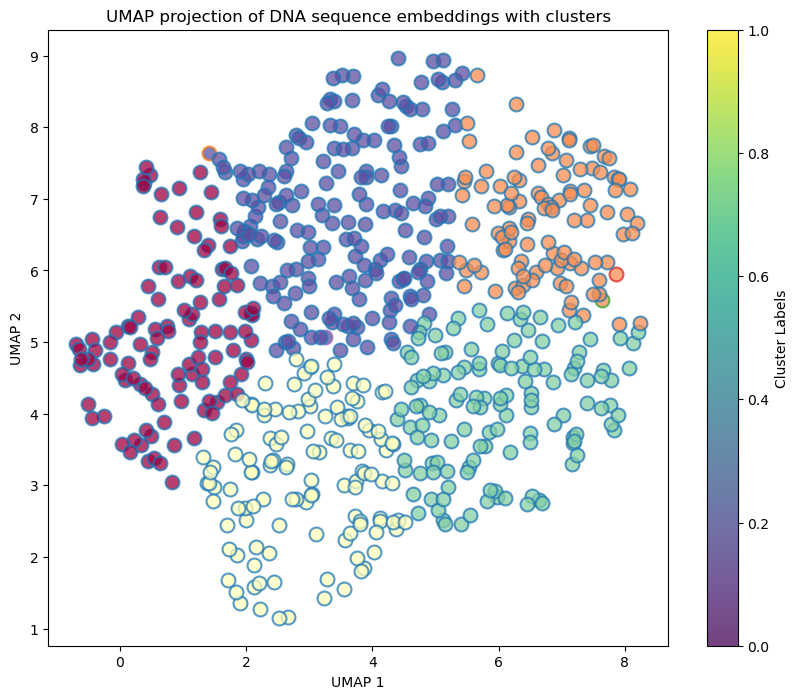

In [61]:
# Install required libraries
# !pip install biopython transformers torch tqdm umap-learn matplotlib einops dnabert

# Import required libraries
import torch
from transformers import AutoTokenizer, BertModel
from Bio import SeqIO
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture
import requests
import gzip
from io import BytesIO, StringIO
import os
import warnings
warnings.filterwarnings("ignore")

# Define the URLs for the organisms
organisms_urls = {
    'human': 'http://ftp.ensembl.org/pub/release-103/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.MT.fa.gz',
    'mouse': 'http://ftp.ensembl.org/pub/release-103/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.chromosome.MT.fa.gz',
    'rat': 'http://ftp.ensembl.org/pub/release-103/fasta/rattus_norvegicus/dna/Rattus_norvegicus.Rnor_6.0.dna.chromosome.MT.fa.gz',
    'zebrafish': 'http://ftp.ensembl.org/pub/release-103/fasta/danio_rerio/dna/Danio_rerio.GRCz11.dna.chromosome.MT.fa.gz',
}

# Function to download and decompress a dataset
def download_ensembl_dataset(url):
    print(f"Downloading dataset from {url}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    compressed_file = BytesIO(response.content)
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    text_content = decompressed_file.read().decode('utf-8')
    records = list(SeqIO.parse(StringIO(text_content), "fasta"))
    print("Download complete.")
    return records

# Download datasets
all_records = []
organisms = []
for organism, url in organisms_urls.items():
    records = download_ensembl_dataset(url)
    all_records.extend(records)
    organisms.extend([organism] * len(records))

print(f"Total sequences downloaded: {len(all_records)}")

# Function to split sequence into overlapping segments
def split_sequence(sequence, segment_length=200, overlap=100):
    return [sequence[i:i+segment_length] for i in range(0, len(sequence)-segment_length+1, segment_length-overlap)]

# Function to preprocess DNA segments for DNABERT
def preprocess_segments(segments, tokenizer, max_length=512):
    tokenized_segments = tokenizer(segments, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return tokenized_segments

# Automatically accept prompts when loading DNABERT
os.environ["HF_ACCEPT"] = "y"

# Load DNABERT tokenizer and model
print("Loading DNABERT tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = BertModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# Split the sequences into segments and keep track of organisms
segments = []
for record in all_records:
    full_sequence = str(record.seq)
    record_segments = split_sequence(full_sequence)
    segments.extend(record_segments)
    organisms.extend([record.annotations.get("organism", "unknown")] * len(record_segments))

print(f"Number of segments created: {len(segments)}")

# Preprocess segments
print("Preprocessing segments...")
tokenized_segments = preprocess_segments(segments, tokenizer)
print(f"Shape of tokenized segments: {tokenized_segments['input_ids'].shape}")

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenized_segments = {k: v.to(device) for k, v in tokenized_segments.items()}

# Generate DNABERT embeddings
print("Generating DNABERT embeddings...")
with torch.no_grad():
    outputs = model(**tokenized_segments)
    embeddings = outputs.last_hidden_state
print(f"Shape of embeddings: {embeddings.shape}")

# Convert embeddings to numpy array
embeddings_np = embeddings.cpu().numpy()

# Reduce dimensionality from 3D to 2D by averaging over the sequence length
embeddings_mean = np.mean(embeddings_np, axis=1)  # Shape: (batch_size, embedding_size)
print(f"Shape of embeddings_mean: {embeddings_mean.shape}")
print(f"Sample of embeddings_mean: {embeddings_mean[:5]}")

# Apply UMAP to reduce the dimensionality to 2D for visualization
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_mean)
print(f"Shape of UMAP embeddings: {umap_embeddings.shape}")
print(f"Sample of UMAP embeddings: {umap_embeddings[:5]}")

# Ensure the number of clusters does not exceed the number of samples
num_clusters = min(len(umap_embeddings), 5)

# Perform Gaussian Mixture Model (GMM) clustering on the UMAP-reduced embeddings
gmm = GaussianMixture(n_components=num_clusters, random_state=0).fit(umap_embeddings)
labels = gmm.predict(umap_embeddings)
print(f"Number of clusters: {num_clusters}")
print(f"Sample of cluster labels: {labels[:10]}")

# Assign colors to clusters
cluster_colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))

# Assign border colors to organisms
unique_organisms = list(set(organisms))
border_colors = dict(zip(unique_organisms, mcolors.TABLEAU_COLORS))

# Plot the UMAP-reduced embeddings with cluster labels and organism border colors
plt.figure(figsize=(10, 8))
for i, (organism, label) in enumerate(zip(organisms, labels)):
    x = umap_embeddings[i, 0]
    y = umap_embeddings[i, 1]
    internal_color = cluster_colors[label]
    border_color = border_colors[organism]
    plt.scatter(x, y, color=internal_color, edgecolor=border_color, s=100, linewidth=1.5, alpha=0.75)

# Create a legend for the organisms
organism_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markeredgecolor=color, markersize=10, linestyle='') for color in border_colors.values()]
organism_labels = border_colors.keys()

# Create a legend for the clusters
cluster_handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='') for color in cluster_colors]
cluster_labels = [f"Cluster {i}" for i in range(num_clusters)]

# plt.legend(organism_handles, organism_labels, title="Organisms", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(cluster_handles, cluster_labels, title="Clusters", bbox_to_anchor=(1.05, 0.5), loc='upper left')

plt.colorbar(label='Cluster Labels')
plt.title('UMAP projection of DNA sequence embeddings with clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('umap_plot_with_organisms.png')  # Save the plot as an image file
print("Plot saved as 'umap_plot_with_organisms.png'")
plt.show()